# **Dataset and Environment Setup**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaeltalawy/handwriting-signature-datasets")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mostafaeltalawy/handwriting-signature-datasets/versions/1


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers

# **Data Exploration and Understanding**

In [ ]:
# Check dataset path and contents
print("Dataset path:", path)
print("Contents of the dataset directory:")
print(os.listdir(path))

# Recursively explore subdirectories
for root, dirs, files in os.walk(path):
    print(f"Root: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")

Dataset path: /root/.cache/kagglehub/datasets/mostafaeltalawy/handwriting-signature-datasets/versions/1
Contents of the dataset directory:
['Handwriting_Signature_Dataset-2', 'Handwriting_Signature_Dataset-4', 'Handwriting_Signature_Dataset-1', 'Handwriting_Signature_Dataset-3']
Root: /root/.cache/kagglehub/datasets/mostafaeltalawy/handwriting-signature-datasets/versions/1
Subdirectories: ['Handwriting_Signature_Dataset-2', 'Handwriting_Signature_Dataset-4', 'Handwriting_Signature_Dataset-1', 'Handwriting_Signature_Dataset-3']
Files: []
Root: /root/.cache/kagglehub/datasets/mostafaeltalawy/handwriting-signature-datasets/versions/1/Handwriting_Signature_Dataset-2
Subdirectories: ['Handwriting_Signature_Dataset-2']
Files: []
Root: /root/.cache/kagglehub/datasets/mostafaeltalawy/handwriting-signature-datasets/versions/1/Handwriting_Signature_Dataset-2/Handwriting_Signature_Dataset-2
Subdirectories: ['Pred_Data', 'Orginal_Data', 'Pred_Data_classified', 'Train_Data', 'Train_Test_Data', 'Tes

## **Image Path Collection**

In [ ]:
fake = []
real = []

def get_imgs_paths(path, root, subdirectory, directory, folder):
  img_paths = os.path.join(path, root,subdirectory,directory, folder)
  for root , dirs, files in os.walk(img_paths):
    for i in range(len(files)):
      if folder == "forge":
        fake.append(files[i])
      else:
        real.append(files[i])

In [ ]:
get_imgs_paths(path, "Handwriting_Signature_Dataset-1", "Handwriting_Signature_Dataset-1", "Orginal_Data", "forge")
get_imgs_paths(path, "Handwriting_Signature_Dataset-1", "Handwriting_Signature_Dataset-1", "Orginal_Data", "real")
get_imgs_paths(path, "Handwriting_Signature_Dataset-2", "Handwriting_Signature_Dataset-2", "Orginal_Data", "forge")
get_imgs_paths(path, "Handwriting_Signature_Dataset-2", "Handwriting_Signature_Dataset-2", "Orginal_Data", "real")
get_imgs_paths(path, "Handwriting_Signature_Dataset-3", "Handwriting_Signature_Dataset-3", "Orginal_Data", "forge")
get_imgs_paths(path, "Handwriting_Signature_Dataset-3", "Handwriting_Signature_Dataset-3", "Orginal_Data", "real")
get_imgs_paths(path, "Handwriting_Signature_Dataset-4", "Handwriting_Signature_Dataset-4", "Orginal_Data", "forge")
get_imgs_paths(path, "Handwriting_Signature_Dataset-4", "Handwriting_Signature_Dataset-4", "Orginal_Data", "real")

## **Pair Generation for Siamese Network**

In [ ]:
from itertools import combinations

def extract_signer_id(image_name):
    """Extract signer ID from the image filename."""
    return image_name.split('.')[0][3:] # Example: NFI-00602023 -> '023'

def make_pairs(real_images, fake_images):
    """
    Generate positive and negative pairs for Siamese network training.

    Args:
        real_images (list): List of real image filenames.
        fake_images (list): List of fake image filenames.

    Returns:
        positive_pairs: List of tuples (img1, img2) for positive pairs.
        negative_pairs: List of tuples (img1, img2) for negative pairs.
        labels: List of labels (1 for positive, 0 for negative).
    """
    # Group images by signer ID
    real_by_signer = {}
    fake_by_signer = {}

    for img in real_images:
        signer_id = extract_signer_id(img)
        if signer_id not in real_by_signer:
            real_by_signer[signer_id] = []
        real_by_signer[signer_id].append(img)

    for img in fake_images:
        signer_id = extract_signer_id(img)
        if signer_id not in fake_by_signer:
            fake_by_signer[signer_id] = []
        fake_by_signer[signer_id].append(img)

    # Create positive pairs (real-real)
    positive_pairs = []
    for signer_id, images in real_by_signer.items():
        if len(images) > 1:
            positive_pairs.extend(list(combinations(images, 2)))

    # Create negative pairs (real-forged)
    negative_pairs = []
    for signer_id, real_images in real_by_signer.items():
        if signer_id in fake_by_signer:
            forged_images = fake_by_signer[signer_id]
            for real_img in real_images:
                for fake_img in forged_images:
                    negative_pairs.append((real_img, fake_img))

    # Combine pairs with labels
    pairs = positive_pairs + negative_pairs
    labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    return pairs, labels

# Example usage
pairs, labels = make_pairs(real, fake)
print(f"Total positive pairs: {labels.count(1)}")
print(f"Total negative pairs: {labels.count(0)}")

Total positive pairs: 90
Total negative pairs: 477


In [ ]:
pairs[:10]

[('00203002.png', '00203002.png'),
 ('00203002.png', '00203002.png'),
 ('00203002.png', '00203002.png'),
 ('00201002.png', '00201002.png'),
 ('00201002.png', '00201002.png'),
 ('00201002.png', '00201002.png'),
 ('01102011.png', '01102011.png'),
 ('01103011.png', '01103011.png'),
 ('00405004.png', '00405004.png'),
 ('00801008.png', '00801008.png')]

## **Image Loading and Visualization Utilities**

In [ ]:
def find_image_path(root_path, image_name):
    """
    Dynamically locate an image within the dataset's directory structure.

    Args:
        root_path (str): Root directory of the dataset.
        image_name (str): The name of the image file to find.

    Returns:
        str: Full path to the image if found, otherwise None.
    """
    for root, dirs, files in os.walk(root_path):
        if image_name in files:
            return os.path.join(root, image_name)
    return None


def load_image(image_path):
    """
    Load an image from the specified path.

    Args:
        image_path (str): Path to the image.

    Returns:
        numpy.ndarray: The loaded image in RGB format.

    Raises:
        FileNotFoundError: If the image is not found.
    """
    image = cv2.imread(image_path)
    if image is not None:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        raise FileNotFoundError(f"Image not found at path: {image_path}")


def visualize_mixed_pairs(pairs, labels, dataset_path, num_positive=5, num_negative=5, image_size=(128, 128)):
    """
    Visualize both positive and negative image pairs with a single label.

    Args:
        pairs (list): List of tuples containing image file names (img1, img2).
        labels (list): List of labels corresponding to pairs (1 for positive, 0 for negative).
        dataset_path (str): Root path to the dataset containing the images.
        num_positive (int): Number of positive pairs to visualize.
        num_negative (int): Number of negative pairs to visualize.
        image_size (tuple): Target size (height, width) for resizing images.
    """
    # Separate positive and negative pairs
    positive_pairs = [pair for pair, label in zip(pairs, labels) if label == 1]
    negative_pairs = [pair for pair, label in zip(pairs, labels) if label == 0]

    # Choose the number of pairs to visualize
    num_positive = min(num_positive, len(positive_pairs))
    num_negative = min(num_negative, len(negative_pairs))

    # Combine selected positive and negative pairs
    mixed_pairs = positive_pairs[:num_positive] + negative_pairs[:num_negative]
    mixed_labels = [1] * num_positive + [0] * num_negative

    # Plot the pairs
    total_samples = num_positive + num_negative
    plt.figure(figsize=(10, total_samples * 3))

    for i, (pair, label) in enumerate(zip(mixed_pairs, mixed_labels)):
        # Dynamically find the paths for both images
        img1_path = find_image_path(dataset_path, pair[0])
        img2_path = find_image_path(dataset_path, pair[1])

        try:
            # Load images
            img1 = load_image(img1_path)
            img2 = load_image(img2_path)

            # Resize images to the same dimensions
            img1_resized = cv2.resize(img1, image_size)
            img2_resized = cv2.resize(img2, image_size)

            # Concatenate images horizontally
            concatenated = np.hstack([img1_resized, img2_resized])

            # Display the concatenated images
            plt.subplot(total_samples, 1, i + 1)
            plt.imshow(concatenated)
            plt.title(f"Label: {label} (Same: {label == 1})")
            plt.axis("off")

        except FileNotFoundError as e:
            print(e)

    plt.tight_layout()
    plt.show()


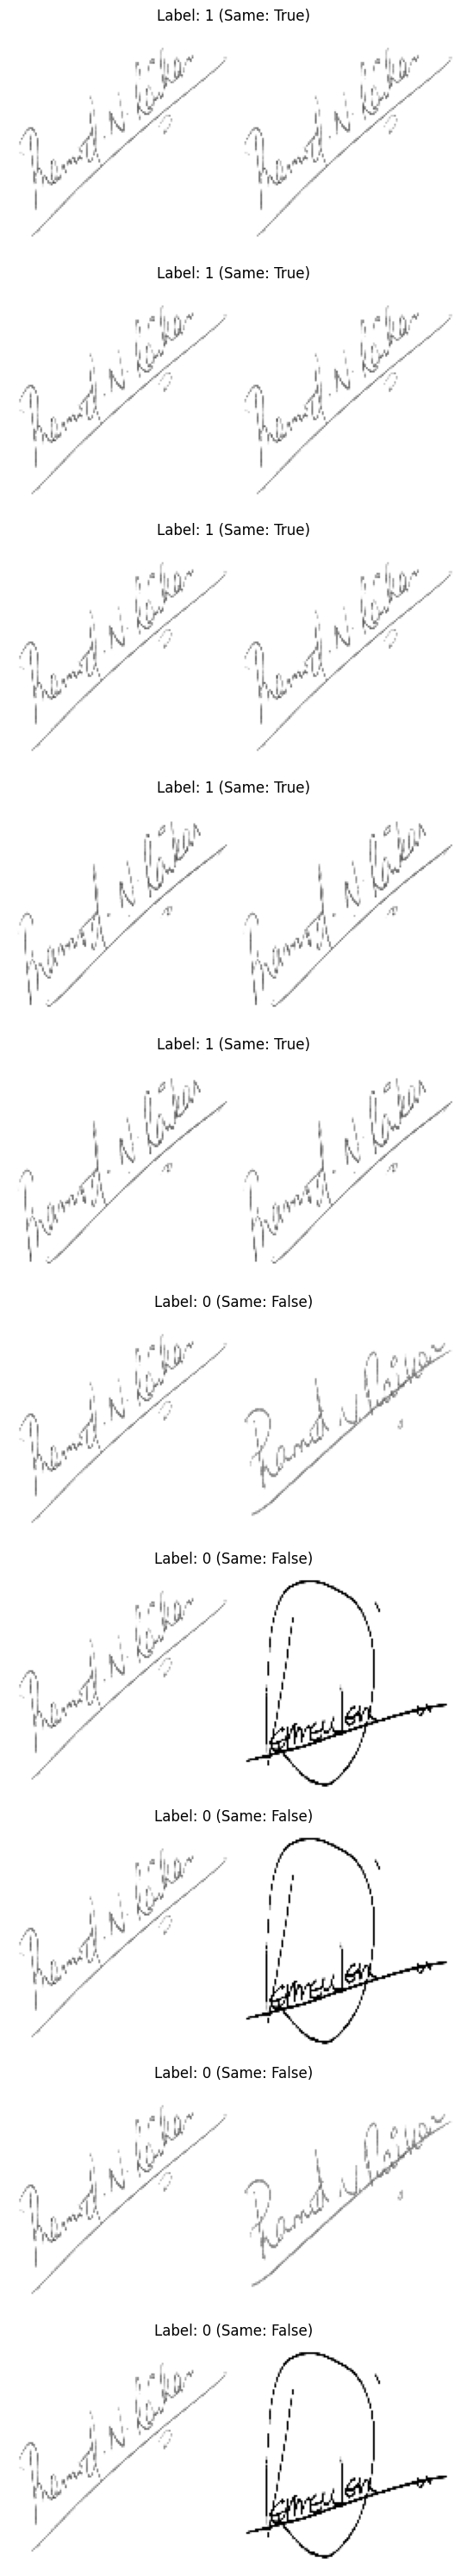

In [ ]:
# Visualize 5 positive and 5 negative pairs with a single label per pair
visualize_mixed_pairs(pairs, labels, path, num_positive=5, num_negative=5, image_size=(128, 128))

# **Data Preprocessing and Model Architecture**

In [ ]:
# Constants
INPUT_SHAPE = (128, 128, 1)
MARGIN = 0.5

## **Image Preprocessing Function**

In [ ]:
def load_and_preprocess_image(image_path, input_shape=INPUT_SHAPE):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        img = cv2.resize(img, input_shape[:2])
        img = (img - np.mean(img)) / np.std(img)
        return img.reshape(input_shape)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [ ]:
def build_base_network(input_shape=INPUT_SHAPE):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(32, activation=None)(x)
    return models.Model(inputs=input_layer, outputs=output_layer)

## **Siamese Network Architecture**

In [ ]:
def build_siamese_network(input_shape=INPUT_SHAPE):
    base_network = build_base_network(input_shape)
    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    embedding_1 = base_network(input_1)
    embedding_2 = base_network(input_2)

    similarity = layers.Dot(axes=-1, normalize=True)([embedding_1, embedding_2])
    siamese_model = models.Model(inputs=[input_1, input_2], outputs=similarity)
    return siamese_model

 ## **Contrastive Loss Function**

In [ ]:
# Custom Loss
def contrastive_loss(margin=MARGIN):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

## **Data Augmentation and Batch Generation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_image(image):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=(0.8, 1.2),
        horizontal_flip=True
    )
    return next(datagen.flow(image[np.newaxis, ...], batch_size=1))[0]


def generate_batches(path, pairs, labels, batch_size=32, input_shape=(128, 128, 1), augment=False):
    def safe_load_image(image_path, input_shape):
        """Safely load and preprocess a single image."""
        try:
            full_path = find_image_path(path, image_path)
            if not full_path:
                print(f"Image path not found: {image_path}")
                return None

            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Could not read image: {full_path}")
                return None

            img = cv2.resize(img, input_shape[:2])
            img = img.astype(np.float32) / 255.0
            return img.reshape(input_shape)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def generator():
        while True:
            # Shuffle indices to randomize batch selection
            indices = np.random.permutation(len(pairs))

            for start in range(0, len(pairs), batch_size):
                # Select batch indices
                batch_indices = indices[start:start + batch_size]

                # Prepare batch data
                batch_img1 = []
                batch_img2 = []
                batch_labels = []

                for idx in batch_indices:
                    # Load images
                    img1 = safe_load_image(pairs[idx][0], input_shape)
                    img2 = safe_load_image(pairs[idx][1], input_shape)

                    # Apply augmentation if specified
                    if augment and img1 is not None and img2 is not None:
                        img1 = augment_image(img1)
                        img2 = augment_image(img2)

                    # Only add valid image pairs
                    if img1 is not None and img2 is not None:
                        batch_img1.append(img1)
                        batch_img2.append(img2)
                        batch_labels.append(labels[idx])

                # Ensure we have at least one valid pair
                if len(batch_img1) > 0:
                    # Convert to numpy arrays
                    batch_img1 = np.array(batch_img1)
                    batch_img2 = np.array(batch_img2)
                    batch_labels = np.array(batch_labels, dtype=np.float32)

                    # Yield as a tuple matching the expected structure
                    yield (batch_img1, batch_img2), batch_labels

    # Create TensorFlow dataset with correct signature
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32),
                tf.TensorSpec(shape=(None, *input_shape), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )


## **Model Training and Evaluation**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_model(path, model, pairs, labels, epochs=50, batch_size=32, validation_split=0.2):
    try:
        # Ensure we have valid pairs
        if len(pairs) == 0:
            raise ValueError("No valid image pairs found")

        # Shuffle and split data into training and validation sets
        indices = np.arange(len(pairs))
        np.random.shuffle(indices)
        split_idx = int(len(pairs) * (1 - validation_split))

        train_indices = indices[:split_idx]
        val_indices = indices[split_idx:]

        train_pairs = [pairs[i] for i in train_indices]
        train_labels = [labels[i] for i in train_indices]

        val_pairs = [pairs[i] for i in val_indices]
        val_labels = [labels[i] for i in val_indices]

        # Create datasets
        train_dataset = generate_batches(path, train_pairs, train_labels, batch_size, augment=True)
        val_dataset = generate_batches(path, val_pairs, val_labels, batch_size, augment=True)

        # Calculate steps per epoch
        train_steps_per_epoch = max(len(train_pairs) // batch_size, 1)
        val_steps_per_epoch = max(len(val_pairs) // batch_size, 1)

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=contrastive_loss(),
            metrics=['accuracy']
        )

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, verbose=1
        )

        # Train model
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=val_steps_per_epoch,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

    except Exception as e:
        print(f"Training error: {e}")
        import traceback
        traceback.print_exc()
        return None


# **Main Execution and Results Visualization**

In [ ]:
# Main Function
def main():
    pairs, labels = make_pairs(real, fake)
    print(f"Total positive pairs: {labels.count(1)}")
    print(f"Total negative pairs: {labels.count(0)}")

    model = build_siamese_network()
    # Train model
    history = train_model(path, model, pairs, labels)

    # Check if training was successful
    if history is not None:
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')

        plt.tight_layout()
        plt.show()

    return model

Total positive pairs: 90
Total negative pairs: 477
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7577 - loss: 0.3034 - val_accuracy: 0.1667 - val_loss: 0.1483 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8292 - loss: 0.2459 - val_accuracy: 0.2073 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8489 - loss: 0.2724 - val_accuracy: 0.2073 - val_loss: 0.1828 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8723 - loss: 0.2723
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8701 - loss: 0.2723 - val_accuracy: 0.1585 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8517 - loss: 0.2697 - val_accuracy: 0.1875 - val_loss: 0.1679 - learning_rate: 5.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/st

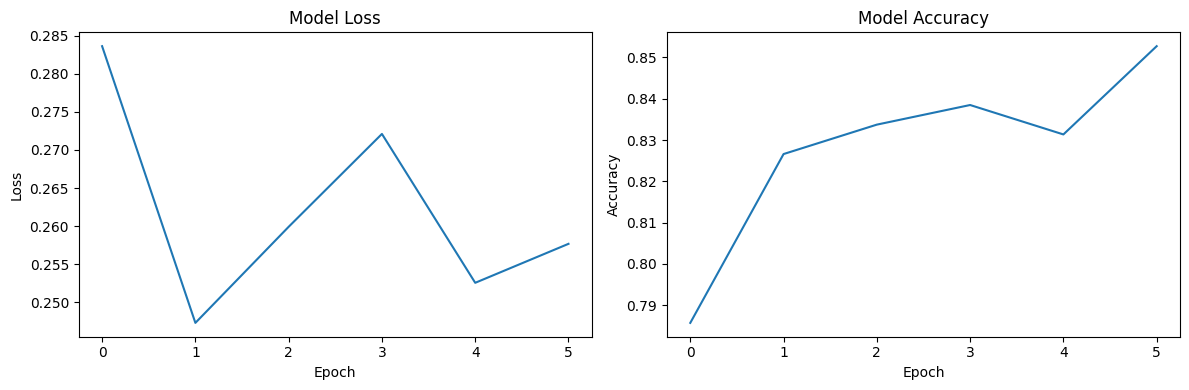

In [ ]:
if __name__ == "__main__":
    main()